In [296]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [297]:
# creating a defined function for importing stock data
def import_securities_data(securities_tickers, enter_time_amount, enter_time_type):

    # time delta method function doesnt take the following date time types, it only takes in days. so we convert the respective time types into days by doing some quick math for the user to convert into days
    other_times_types = ['y', 'Y',  'm', 'M', 'w', 'W']
    
    month_type = ['m', 'M']

    week_type = ['w', 'W']

    year_type = ['y', 'Y']

    # if statement that allows us to make a conditional statement to see if the user has inputted any of the time types listed under the other_times_types variable. if so is the case it moves on to the following if conditional statements and executes the respective function under the if statement that the conditional value was true
    if enter_time_type in other_times_types:

        if enter_time_type in month_type:

            enter_time_amount = 30 * enter_time_amount

        elif enter_time_type in week_type:

            enter_time_amount = 7 * enter_time_amount
        
        elif enter_time_type in year_type:

            enter_time_amount = 365 * enter_time_amount

    
    # create a variable to assign the end date and start dates of the data that we want to download, the start date is dynamic and customizable to the user's preference of the data one wants to download
    # credit to John Droescher for this part of the code
    start_date = dt.datetime.today() - pd.Timedelta(enter_time_amount, "d")
    end_date = dt.datetime.today()
    
    # this returns all of the securities related historical prices data utilizing yahoo finance's API
    return yf.download(start= start_date, end= end_date, tickers= securities_tickers)

In [298]:
# creating a list of the ticker names of the stocks we want to use for our portfolio. This will help us in downloading the data from the yf alius library that was declared. as well used for creating the ticker column in our pandas dataframe
stock_pick = ['AAPL', 'MSFT', 'F', 'O', 'BND', 'KO', 'JPM']
etf_pick = ['SPY', 'IWM', 'DIA']

# this will download all of the relevant data related to our constituent's of selected stocks and etfs
portfolio_individual = import_securities_data(stock_pick, 10, "y")['Adj Close']
portfolio_etf = import_securities_data(etf_pick, 10, "y")['Adj Close']
port_etf_stock = import_securities_data(stock_pick + etf_pick, 10, "y")['Adj Close']

# calculateing the returns for individual stock and etf portfolios
portfolio_individual_rets = portfolio_individual.pct_change().dropna()
portfolio_etf_rets = portfolio_etf.pct_change().dropna()
port_etf_stock_rets = port_etf_stock.pct_change().dropna()

[*********************100%%**********************]  7 of 7 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  10 of 10 completed


# Part 1:

## Setting Up Dataframe:

In [299]:
# creating a dictionary with an embedded list of the stock tickers in order to create a dataframe
# 'ticker' is the title of our column. the list with the stock symbols is our values within our column that has the title 'ticker'
stock_pick_dict = { 'ticker': ['AAPL', 'MSFT', 'F', 'O', 'BND', 'KO', 'JPM']}

# creating the dataframe using pandas library and setting the tickers as our index for the dataframe
df = pd.DataFrame(stock_pick_dict)
df.set_index('ticker', inplace = True)

# all assets that are being held in this portfolio are equal weighted. so we want to make sure of that by taking the total of a pie, 100%, and divide it by the count of stocks that we have within our portfolio
df['portfolio_weight'] = np.divide(1, len(stock_pick)).round(4)

## Definitions Method Functions:

In [300]:
# setting a definition method to calculate the annual volatility of the stock portfolio
def calc_annual_vol():

    # creating a variable that offsets today's date by 3 months
    last_three_months = pd.to_datetime('now') - pd.DateOffset(months=3)
    
    # calculating the percentage change to get the daily returns from the three months worth of trailing data
    daily_returns_data = portfolio_individual.loc[last_three_months:, :].pct_change()

    # getting the annualized volatility for each of the stocks. Credit to Yves Hilpisch the author for the python for finance V.2018 (pg.19)
    annualized_volatility_data = (daily_returns_data.std() * np.sqrt(252)).round(4)

    # appending the data to the dataframe
    df['annualized_volatility'] = annualized_volatility_data

    return annualized_volatility_data


# creating a definition function to calculate beta. credit to: https://github.com/sammuharem/beta-calculator/blob/main/Stock%20Beta%20Calculator.py look at the calculatebeta function
def beta_calc():

    twelve_month_of_data = pd.to_datetime('now') - pd.DateOffset(months=12)

    # looping through the columns of our etf return data so that we can iterate through the names of the etfs within the portfolio
    for etf in portfolio_etf_rets.columns:
        
        # looping through the columns of our individual stock return data so that we can iterate through the names of the etfs within the portfolio
        for stock in portfolio_individual_rets.columns:

            # calculating covariance between stock returns and market returns, using numpy's universal functions 
            covariance = np.cov(portfolio_individual_rets.loc[twelve_month_of_data:, stock], portfolio_etf_rets.loc[twelve_month_of_data:, etf])

            # caluculating variance of market returns, using numpy's universal functions 
            variance = np.var(portfolio_etf_rets.loc[twelve_month_of_data:, etf])

            # implementing the beta formula. here we are extracting the covariance between the stock returns and market returns from the matrix that was created in the previous code with the covariance variable. we then take that covariance and divide it by the variance formula
            df.loc[stock, f'Beta against {etf}'] = covariance[0,1] / variance
            
    return 


# calculating average weekly drawdown
def calc_avg_weekly_drawdown():
    
    # we are setting a window of 5 since a trading week consists of 5 days (Monday - Firday). This variable will be used to apply the rolling method. this way we can get the weekly drawdown for each day.
    window = 5

    # using the drawdown formula -->  (week low price - week high price) divided by week high price --- and then taking the mean of each to get the average weekly drawdown. Partial credit to Kayla, Ashanti and Edosa's repo
    # In this case we take the rolling 5 day window to get the weekly drawdown of each day. Then we filter for the last previous day by using iloc and find the average weekly drawdown from those 20 days of weekly drawdown data
    df["average_weekly_drawdown"] = ((port_etf_stock.rolling(window=window).min() - port_etf_stock.rolling(window=window).max()) / port_etf_stock.rolling(window=window).max()).iloc[-20:,:].mean()

    return


# calculating maximum weekly drawdown
def calc_max_weekly_drawdown():

    window = 5

    # using the drawdown formula --> (week low price - week high price) divided by week high price --- and then taking the max of each variable within the formila  to get the maximum weekly drawdown. Partial credit to Kayla, Ashanti and Edosa's repo
    # In this case we take the rolling 5 day window to get the weekly drawdown of each day. Then we filter for the previous 20 days of weekly drawdown data and find the maximum day that had the highest weekly drawdown. we need to use the min function here because we are trying to find the maximum drawdown, drawdowns is the biggest decline of stock within a time period. In this case all of our returns are negative and we are trying to find out what is the maximum number that our stock can fall
    df["maximum_weekly_drawdown"] = ((port_etf_stock.rolling(window=window).min() - port_etf_stock.rolling(window=window).max()) / port_etf_stock.rolling(window=window).max()).iloc[-20:,:].min()
    
    return


# calculating total returns
def calc_total_returns():

    df["total_returns"] = (((port_etf_stock.loc[port_etf_stock.index.max(), : ] - port_etf_stock.loc[port_etf_stock.index.min(), :]) / port_etf_stock.loc[port_etf_stock.index.min(), :]) * 100).round(3)

    return


# culating annualized total return
def calc_annual_ret():

    df["annualized_returns"] = ((((1 + ((port_etf_stock.loc[port_etf_stock.index.max(), :] - port_etf_stock.loc[port_etf_stock.index.min(), :]) / port_etf_stock.loc[port_etf_stock.index.min(), :] )) ** (1/10)) - 1) * 100).round(3)
    
    return

In [301]:
# creating a function to execute all of the definition functions that where created at once and print out the results at the end
def init_calc_part1():
    
    # column 3
    calc_annual_vol()

    # column 4
    beta_calc()

    # column 5
    calc_avg_weekly_drawdown()

    # column 6
    calc_max_weekly_drawdown()

    # column 7
    calc_total_returns()

    # column 8
    calc_annual_ret()

    # print results
    return df

## Part #1 Complete: Results:

In [302]:
init_calc_part1()

,portfolio_weight,annualized_volatility,Beta against DIA,Beta against IWM,Beta against SPY,average_weekly_drawdown,maximum_weekly_drawdown,total_returns,annualized_returns
ticker,,,,,,,,,
AAPL,0.1429,0.1807,0.946064,0.340483,1.053183,-0.027456,-0.064343,945.261,26.451
MSFT,0.1429,0.1856,0.870165,0.218166,1.136914,-0.024438,-0.033837,1184.655,29.086
F,0.1429,0.3428,1.599828,0.901664,1.253150,-0.031203,-0.058085,30.488,2.697
O,0.1429,0.1836,0.876501,0.476995,0.645522,-0.018080,-0.034483,101.028,7.232
BND,0.1429,0.0581,0.062372,0.059285,0.076195,-0.006727,-0.011843,16.916,1.575
KO,0.1429,0.1250,0.525413,0.124636,0.338848,-0.015389,-0.031842,115.901,8.000
JPM,0.1429,0.1214,1.130828,0.490918,0.823380,-0.019066,-0.031189,335.109,15.840


# Part #2

## Setting Up Dataframe:

In [303]:
# creating a dictionary with an embedded list of the stock tickers in order to create a dataframe
etf_pick_dict = { 'ticker': etf_pick}

# creating the pandas dataframe and setting tickers column as our index
df2 = pd.DataFrame(etf_pick_dict)
df2.set_index("ticker", inplace= True)

In [304]:
# calculating the sum return of our individuals stocks to get the portfolio daily returns data
annual_ret_portfolio_individual = portfolio_individual.pct_change().dropna() * np.divide(1, len(stock_pick)).round(4)
annual_ret_portfolio_individual['port_ret_daily'] = annual_ret_portfolio_individual.sum(axis=1)

# calculating each of the etfs daily returns
annual_ret_portfolio_etf = portfolio_etf.pct_change().dropna()

## Definition Method Functions:

In [305]:
# creating a definition method to calculate the correlation of our portfolio returns against the etfs returns
def calc_port_corr():
    
    one_year_of_data = pd.to_datetime('now') - pd.DateOffset(years=1)

    # create a for loop that reads the column names that contains the names of our etfs in the dataframe
    for etf in annual_ret_portfolio_etf.columns:

        # take the returns of our portfolio and the returns of the looped etf and apply the correlation method in python to calculate correlation. we then append the result to the index of etfs in our dataframe
        df2.loc[etf, 'Correlation Against ETF'] = annual_ret_portfolio_individual.loc[one_year_of_data:, :]['port_ret_daily'].corr(annual_ret_portfolio_etf.loc[one_year_of_data:, :][etf])

    return


# creating method to calculate the covariance of the portfolio returns against the etfs returns
def calc_cov():
    
    one_year_of_data = pd.to_datetime('now') - pd.DateOffset(years=1)

    # looping through the column names to get the names of the etfs one by one and passing them through the set of instructions that gets the respective returns data and makes the calculations
    for etf in annual_ret_portfolio_etf.columns:

        # utilizing the covariance universal function from numpy to calculate the covaraince of the portfolio returns against the etf returns
        df2.loc[etf, 'Covariance of Portfolio vs ETF'] = np.cov(annual_ret_portfolio_individual.loc[one_year_of_data:, :]['port_ret_daily'], annual_ret_portfolio_etf.loc[one_year_of_data:, :][etf])[0,1]
        
    return


# credit to https://www.youtube.com/watch?v=0oU5dfzo040, and Alex Guerrero https://github.com/CCNY-Analytics-and-Quant/Portfolio-analysis-2/blob/main/Portfolio_Analysis.ipynb
def calc_track_err():
    
    for etf in annual_ret_portfolio_etf.columns:
        
        # calculating the difference between the portfolio returns and the etf return
        df2.loc[etf, 'Tracking Errors'] = (annual_ret_portfolio_individual['port_ret_daily'] - annual_ret_portfolio_etf[etf]).std()

    return 


# creating a method to calculate the sharpe ratio. sharpe ratio code partial credit: https://www.youtube.com/watch?v=s0bxoD_0fAU
def calc_sharpe_ratio():

    # creating web-scraper to get current risk-free rate from the web. we use the 3-month treasury yield rate for this from Yahoo Finance or CNBC. credit: https://www.youtube.com/watch?v=XVv6mJpFOb0&t=1s
    # getting necessary libraries
    import requests
    from bs4 import BeautifulSoup

    # sending a request to web api to gain access to the website in html form
    html_text = requests.get('https://www.cnbc.com/quotes/US3M').text

    # using beauftiful soup library to make the html readable
    soup = BeautifulSoup(html_text, 'lxml')

    # setting a variable to hold the piece of text that we are extracting from the peace of html that holds the 3-month treasury risk free rate
    risk_free_rate_10yr = soup.find('span' , class_ = 'QuoteStrip-lastPrice').text.strip('%')

    # take the text and convert it into a float number and take out any white spaces
    risk_free_rate_10yr = float(risk_free_rate_10yr.strip())

    # the risk free rate is set to an annual rate by default. calculate the daily risk-free rate as we are dealing with daily data in our pandas dataframe
    daily_risk_free_rate = ((1 + (risk_free_rate_10yr/100)) ** (1/252)) -1
    
    # getting etf names from our pandas dataframe column's that contain our return data
    for etf in annual_ret_portfolio_etf.columns:

        # calculate excess returns by subtracting the risk-free rate
        excess_returns = annual_ret_portfolio_etf[etf] - daily_risk_free_rate

        # calculate the average excess return
        average_excess_return = np.mean(excess_returns)
        
        # calculate the standard deviation of excess returns
        std_excess_return = np.std(excess_returns)
        
        # calculate the Sharpe Ratio and append to the dataframe respective to the index
        df2.loc[etf, 'Sharpe Ratio'] = average_excess_return / std_excess_return

    return


# creating a method to calculate the annual volatility spread
def calc_annual_vol_spread():

    # getting etf name
    for etf in annual_ret_portfolio_etf.columns:

        # getting the standard deviation of our etf daily returns
        etf_vol = annual_ret_portfolio_etf[etf].std()

        # getting the standard deviation of our equity portfolio daily returns
        port_vol = annual_ret_portfolio_individual['port_ret_daily'].std()

        # calculating the annualized volatility spread and appending it to the dataframe respective to the index
        df2.loc[etf, 'Annualized Volatility Spread'] = ((port_vol - etf_vol) * np.sqrt(252))
    
    return

In [306]:
def init_calc_part2():

    # column 2
    calc_port_corr()

    # column 3
    calc_cov()

    # column 4
    calc_track_err()

    # column 5
    calc_sharpe_ratio()

    # column 6
    calc_annual_vol_spread()

    # show the results
    return df2

## Part #2 Complete: Results

In [307]:
init_calc_part2()

,Correlation Against ETF,Covariance of Portfolio vs ETF,Tracking Errors,Sharpe Ratio,Annualized Volatility Spread
ticker,,,,,
SPY,0.828441,0.000043,0.004258,0.029839,-0.008335
IWM,0.683319,0.000060,0.008039,0.011539,-0.055148
DIA,0.799327,0.000036,0.004487,0.025962,-0.006919


# Part #3:

In [308]:
# function to create the correlation matrix heatmap
def port_corr_matrix_plot():

    # the date from one year ago
    one_year_of_data = pd.to_datetime('now') - pd.DateOffset(years=1)

    # calculating the correlation matrix using the pearson method
    corr_matrix_data = port_etf_stock.loc[one_year_of_data:, :].corr(method = 'pearson')

    # plotting the correlation method in a Heatmap. credit to Alex Guerrero
    sns.heatmap(corr_matrix_data, annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.xticks(rotation = 90)
    plt.show()

    return

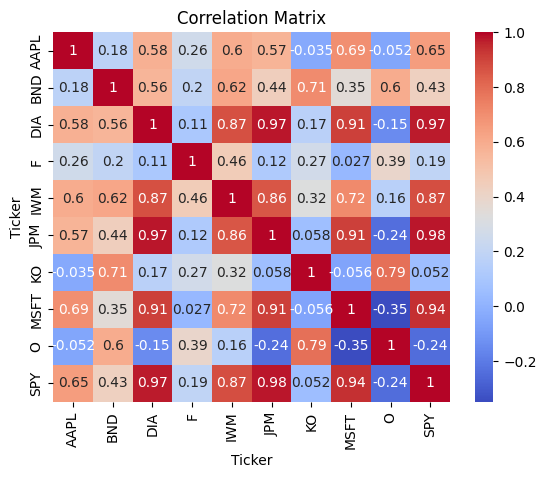

In [309]:
port_corr_matrix_plot()